In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

In [2]:
# Load the cleaned dataset
df = pd.read_csv('output_dataset.csv')
df['Result'] = df['Result'].replace({1: 1, 2: 0})

# Prepare data for modeling
X = df[['Total Bilirubin', 'Alkphos Alkaline Phosphotase',
        'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
        'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
        'Bilirubin Ratio', 'SGOT/SGPT Ratio', 'Protien Ratio']]
y = df['Result']               

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [3]:
# Define Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'penalty': ['l1', 'l2'],                   # Try L2 penalty
    'C': [0.001, 0.1, 0.5, 1, 5, 10],                 # Higher C to reduce underfitting
    'solver': ['liblinear', 'saga'],            # Compatible solvers
    'class_weight': [None, 'balanced'],         # Handle class imbalance
    'l1_ratio': [0]                             # Ignore for L2
}


# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'el

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'}


/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [4]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate training accuracy
training_accuracy = best_model.score(X_train_scaled, y_train)

# Perform K-Fold Cross-Validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)
cv_mean_accuracy = cv_scores.mean()

# Create a DataFrame to store accuracy results
results = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Mean Cross-Validation Accuracy'],
    'Score': [training_accuracy * 100, cv_mean_accuracy * 100,]
})
results



/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/tina/anaconda3/envs/Tina/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'el

,Metric,Score
0,Training Accuracy,73.374878
1,Mean Cross-Validation Accuracy,73.081629


In [5]:
# Predict on test data
y_pred = best_model.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report into a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

class_report_df


,precision,recall,f1-score,support
0,0.584091,0.292877,0.390133,1755.000000
1,0.764024,0.916515,0.833351,4384.000000
accuracy,0.738231,0.738231,0.738231,0.738231
macro avg,0.674057,0.604696,0.611742,6139.000000
weighted avg,0.712585,0.738231,0.706645,6139.000000


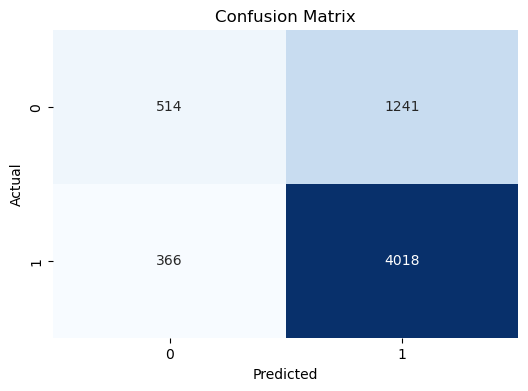

In [6]:

# Predict on test data
y_pred = best_model.predict(X_test_scaled)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



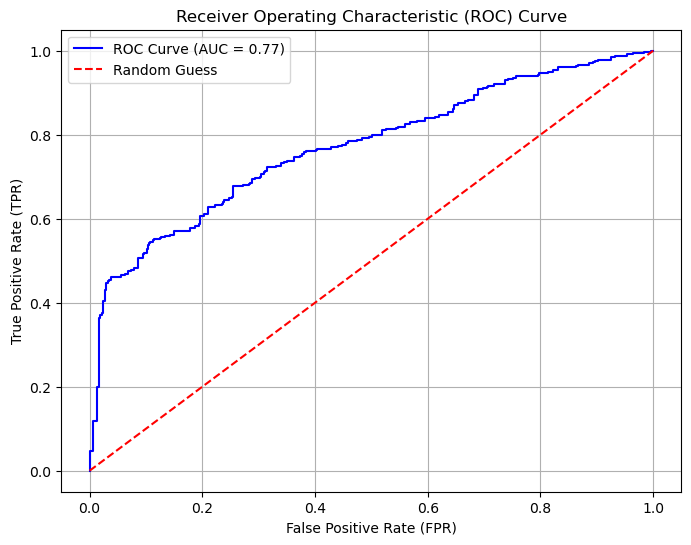

In [7]:
# Predict probabilities for the positive class (class 1)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(True)
plt.show()


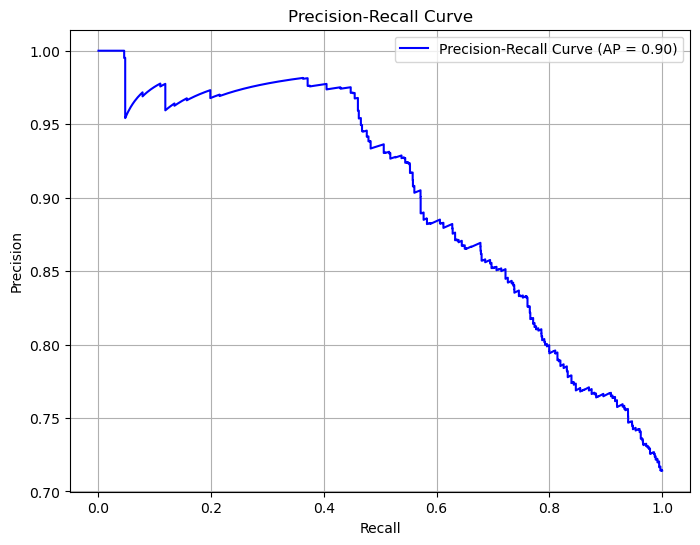

In [9]:
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)

# Calculate average precision score (AUC for PR curve)
avg_precision = average_precision_score(y_test, y_prob, pos_label=1)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()